<div class = "alert alert-danger" style = "border-radius:10px">**DELIVERABLE: ** We want to modify the soft-margin SVM to be able to accomodate unbalanced data. Describe how to change the formulation such that we can control the balance of the errors from each class. Code an example and apply it to the following problem.</div>

(320, 2) (320,)


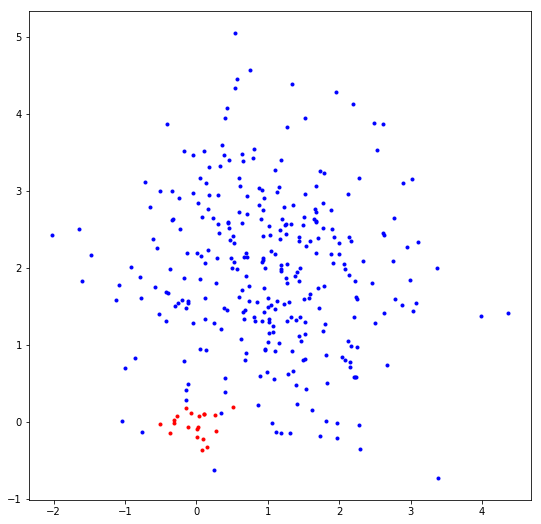

In [100]:
%matplotlib inline
import numpy as np
Nneg = 20
Npos = 300

m1 = [0.,0.]
s1 = [[0.05,0],[0,0.05]]
m2 = [1.,2.]
s2 = [[1,0],[0,1]]
c1 = np.random.multivariate_normal(m1,s1,Nneg)
c2 = np.random.multivariate_normal(m2,s2,Npos)



x= np.r_[c1,c2]
yneg = -np.ones(c1.shape[0])
ypos = np.ones(c2.shape[0])
y= np.r_[yneg, ypos]


print (x.shape,y.shape)
import matplotlib.pyplot as plt


plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')


plt.gcf().set_size_inches((9,9))

Solving the problem using weights and Alberto's nice function, the weights defined in terms of the relative sizes of the data sets

In [101]:
from cvxpy import *
import numpy

def foo(Cneg=1, Cpos=0.01):
    d = x.shape[1]
    print(f'Cneg={Cneg}\nCpos={Cpos}')

    # Construct the problem.
    # Declare variables
    a = Variable(d)
    b = Variable()
    xi = Variable(Nneg)
    xj = Variable(Npos)
    objective = Minimize(norm(a) + Cneg*sum(xi) + Cpos*sum(xj))
    constraints = [multiply(yneg, c1*a+b)>=1-xi, multiply(ypos, c2*a+b)>=1-xj, xi>=0, xj>=0]

    prob = Problem(objective, constraints)
    prob.solve()
    print(prob.status)

    xx,yy = np.meshgrid(np.linspace(-3,6,200),np.linspace(-4,6,200))
    viz=np.c_[xx.ravel(),yy.ravel()]


    z = np.dot(viz,a.value)+b.value

    plt.plot(c1[:,0],c1[:,1],'r.')
    plt.plot(c2[:,0],c2[:,1],'b.')
    plt.gca().set_xlim([-3.,6.])
    plt.gca().set_ylim([-4.,6.])
    plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-3,6,-4,6),alpha=0.3, vmin=-1, vmax=1)
    plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])

    plt.gcf().set_size_inches((9,9))

Cneg=15.0
Cpos=1.0
optimal


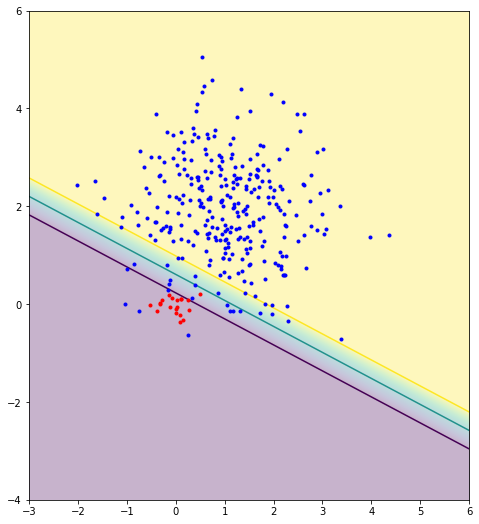

In [102]:
pos_value=np.max((Nneg,Npos))/Npos
neg_value=np.max((Nneg,Npos))/Nneg

foo(Cneg=neg_value, Cpos=pos_value)


Which is an efficient seperation of the data sets

##### Second exploration using closest points in the data set

We define the center of the points to be able to check the distance

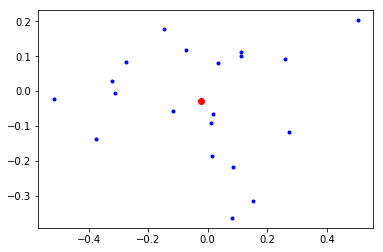

In [103]:
c1_x=c1[:,0].mean()
c1_y=c1[:,1].mean()
c1_center=np.array([c1_x,c1_y])

plt.plot(c1[:,0],c1[:,1],'b.')
plt.plot(c1_center[0],c1_center[1],'ro')
plt.show()


We now take all the nearest points from c2 to the center of c1

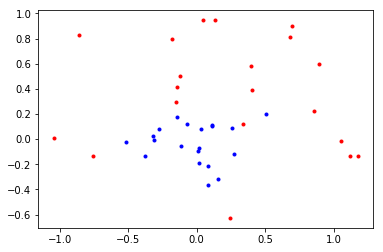

In [104]:
Y=[]
for i in range(c2.shape[0]):
    Y.append(numpy.linalg.norm(c2[i]-c1_center))

points=np.zeros((20,2))
for i in range(20):
    points[i]=c2[np.argpartition(Y,c1.shape[0])[:20][i]]


plt.plot(points[:,0],points[:,1],'r.')
plt.plot(c1[:,0],c1[:,1],'b.')
plt.show()

Let's now solve the problem with these points

In [105]:
x= np.r_[c1,points]
yneg = -np.ones(c1.shape[0])
ypos = np.ones(points.shape[0])
y= np.r_[yneg, ypos]


#my code
from cvxpy import *
import numpy

d = x.shape[1] 
N = x.shape[0]
C = 50.

# Construct the problem.
# Declare variables
a = Variable(d)
b = Variable()
error = 1.

#solve with minimization of norm of a and the violation C
objective = Minimize(norm(a)+C*sum(error))
constraints = [multiply(y,x*a+b)>=(1-error)]

prob = Problem(objective,constraints)
prob.solve()
prob.status

'optimal'

And now plot all the points and the boundary

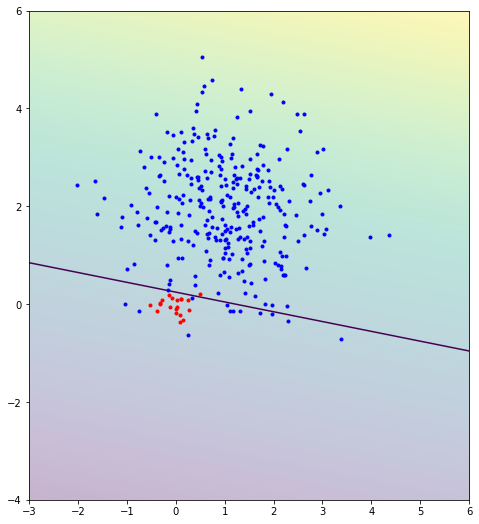

In [106]:
xx,yy = np.meshgrid(np.linspace(-3,6,200),np.linspace(-4,6,200))
viz=np.c_[xx.ravel(),yy.ravel()]


z = np.dot(viz,a.value)+b.value

plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.gca().set_xlim([-3.,6.])
plt.gca().set_ylim([-4.,6.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-3,6,-4,6),alpha=0.3)
plt.contour(xx,yy,z.reshape((200,200)),[-1,0,1])

plt.gcf().set_size_inches((9,9))

This method however is not effective for points in a circle around c1, as the boudary will fail to take into account the furthest points of c2